In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import sys
from triplet_attention import *
sys.path.append("..")
from basic_tools import *
print(torch.cuda.is_available())

True


In [2]:
def conv3x3(in_planes, out_planes, stride=1, groups=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, groups=groups, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [3]:
class SEModule(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        x = self.avg_pool(input)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return input * x

In [4]:
class Res2NetBottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, downsample=None, stride=1, scales=4, groups=1, se=False,  norm_layer=None):
        super(Res2NetBottleneck, self).__init__()
        if planes % scales != 0:
            raise ValueError('Planes must be divisible by scales')
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        bottleneck_planes = groups * planes
        self.conv1 = conv1x1(inplanes, bottleneck_planes, stride)
        self.bn1 = norm_layer(bottleneck_planes)
        self.conv2 = nn.ModuleList([conv3x3(bottleneck_planes // scales, bottleneck_planes // scales, groups=groups) for _ in range(scales-1)])
        self.bn2 = nn.ModuleList([norm_layer(bottleneck_planes // scales) for _ in range(scales-1)])
        self.conv3 = conv1x1(bottleneck_planes, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.se = SEModule(planes * self.expansion) if se else None
        self.downsample = downsample
        self.att = TripletAttention(bottleneck_planes, 16)
        self.stride = stride
        self.scales = scales

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        xs = torch.chunk(out, self.scales, 1)
        ys = []
        for s in range(self.scales):
            if s == 0:
                ys.append(xs[s])
            elif s == 1:
                ys.append(self.relu(self.bn2[s-1](self.conv2[s-1](xs[s]))))
            else:
                ys.append(self.relu(self.bn2[s-1](self.conv2[s-1](xs[s] + ys[-1]))))
        out = torch.cat(ys, 1)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.se is not None:
            out = self.se(out)

        if self.downsample is not None:
            identity = self.downsample(identity)
        
        out = self.att(out)
        out += identity
        out = self.relu(out)

        return out

In [5]:
class Res2Net(nn.Module):
    def __init__(self, layers, num_classes=100, zero_init_residual=False,
                 groups=1, width=64, scales=4, se=False, norm_layer=None):
        super(Res2Net, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        planes = [int(width * scales * 2 ** i) for i in range(3)]
        self.inplanes = planes[0]
        self.conv1 = conv3x3(3, planes[0])
        self.bn1 = norm_layer(planes[0])
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(Res2NetBottleneck, planes[0], layers[0], scales=scales, groups=groups, se=se, norm_layer=norm_layer)
        self.layer2 = self._make_layer(Res2NetBottleneck, planes[1], layers[1], stride=2, scales=scales, groups=groups, se=se, norm_layer=norm_layer)
        self.layer3 = self._make_layer(Res2NetBottleneck, planes[2], layers[2], stride=2, scales=scales, groups=groups, se=se, norm_layer=norm_layer)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(planes[2] * Res2NetBottleneck.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Res2NetBottleneck):
                    nn.init.constant_(m.bn3.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, scales=4, groups=1, se=False, norm_layer=None):
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, downsample, stride=stride, scales=scales, groups=groups, se=se, norm_layer=norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, scales=scales, groups=groups, se=se, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate=0.001
momentum=0.9
weight_decay=0.0001
batch_size=56
epochs=70
data_path='../data'
model_name='Res2NetWithTrippleAttNoSE'+'epoch='+str(epochs)
print(device)
model=Res2Net([3, 3, 3], groups=6, width=24, scales=6, se=False).to(device)
criterion=nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

cuda:0


In [7]:
trainloader,testloader=get_data_loaders(train_batch_size=batch_size,test_batch_size=batch_size,data_path=data_path)

epoch:0,
train_loss:3.9649,train_acc:9.6820,train_top5_acc:29.1260,test_loss:3.5645,test_acc:15.7500,test_top5_acc:41.0800
epoch:1,
train_loss:3.3272,train_acc:18.9960,train_top5_acc:46.8380,test_loss:3.1523,test_acc:23.1000,test_top5_acc:53.3400
epoch:2,
train_loss:2.8240,train_acc:27.8060,train_top5_acc:59.8840,test_loss:2.6643,test_acc:32.9900,test_top5_acc:63.4100
epoch:3,
train_loss:2.3767,train_acc:36.9800,train_top5_acc:70.2600,test_loss:2.2843,test_acc:38.9900,test_top5_acc:72.9000
epoch:4,
train_loss:2.0148,train_acc:44.9480,train_top5_acc:77.4700,test_loss:1.9712,test_acc:46.3600,test_top5_acc:78.4400
epoch:5,
train_loss:1.7135,train_acc:51.9280,train_top5_acc:83.1580,test_loss:1.7651,test_acc:51.0600,test_top5_acc:82.0300
epoch:6,
train_loss:1.4837,train_acc:57.6420,train_top5_acc:86.8660,test_loss:1.5946,test_acc:55.4600,test_top5_acc:84.6800
epoch:7,
train_loss:1.3109,train_acc:62.0920,train_top5_acc:89.2820,test_loss:1.4609,test_acc:58.9300,test_top5_acc:86.5800
epoch:8,


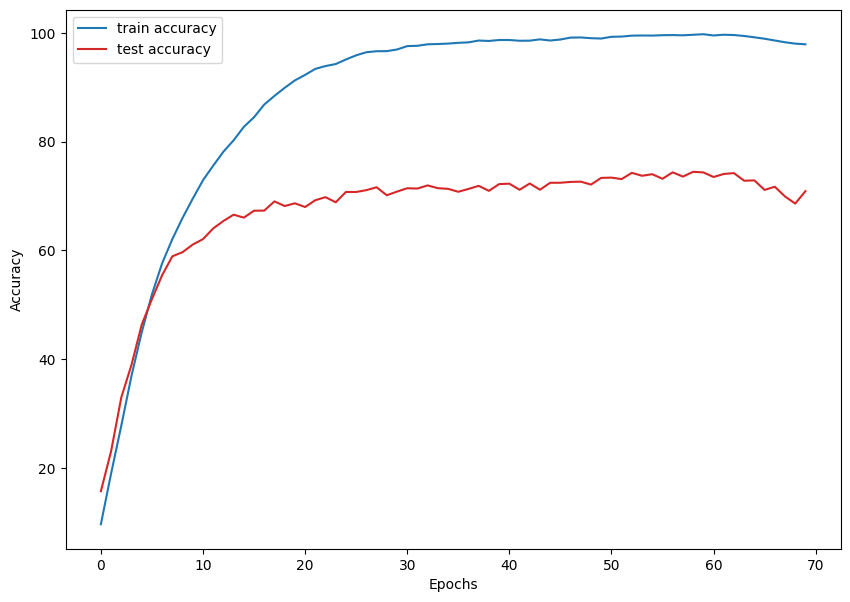

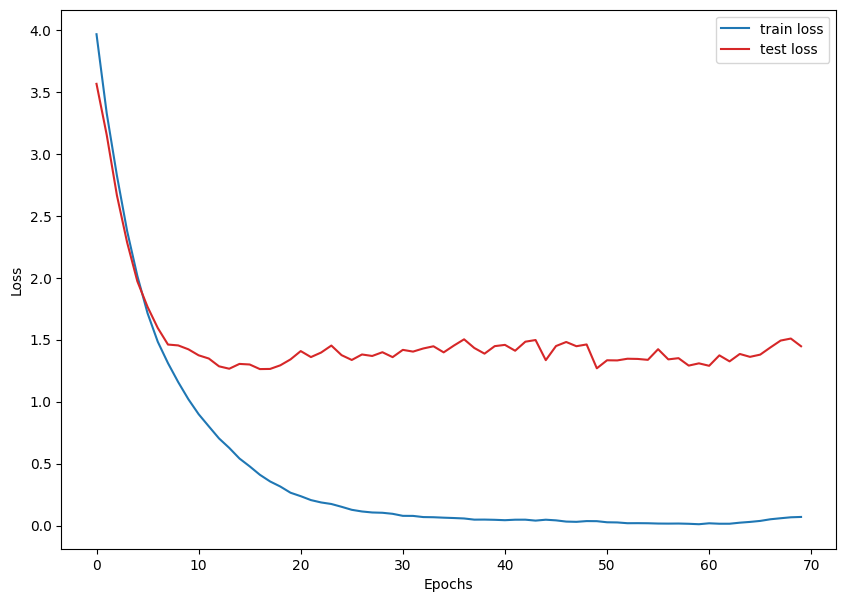

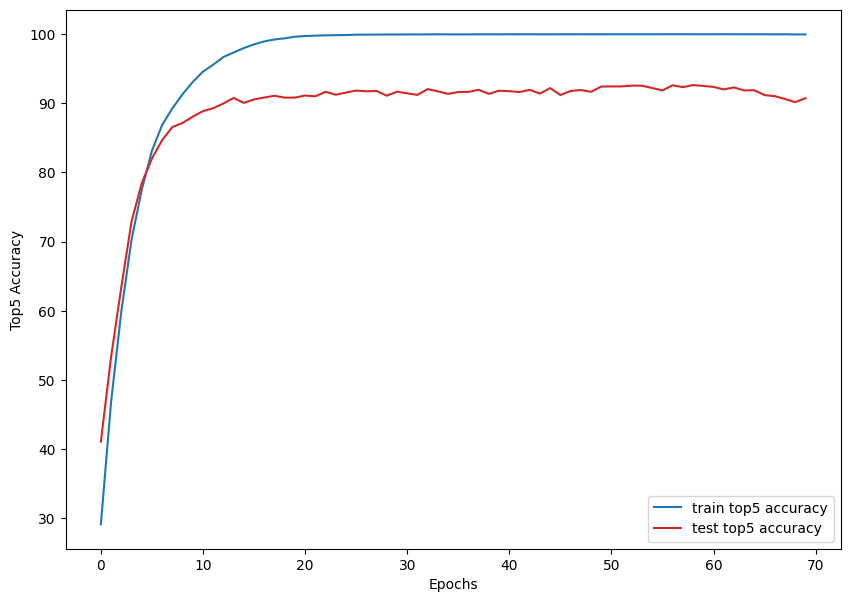

In [8]:
train_lossa, test_lossa = [], []
train_acca, test_acca = [], []
train_top5_acca, test_top5_acca = [], []
for epoch in range(epochs):
    train_loss,train_acc,train_top5_acc=train(model,trainloader,criterion,optimizer,device)
    print('epoch:{},'.format(epoch))
    test_loss,test_acc,test_top5_acc=test(model,testloader,criterion,device)
    print('train_loss:{:.4f},train_acc:{:.4f},train_top5_acc:{:.4f},test_loss:{:.4f},test_acc:{:.4f},test_top5_acc:{:.4f}'.format(train_loss,train_acc,train_top5_acc,test_loss,test_acc,test_top5_acc))
    torch.save(model.state_dict(), model_name+'.pth')
    train_lossa.append(train_loss)
    test_lossa.append(test_loss)
    train_acca.append(train_acc)
    test_acca.append(test_acc)
    train_top5_acca.append(train_top5_acc)
    test_top5_acca.append(test_top5_acc)

#画图
save_plots(train_acca,test_acca,train_lossa,test_lossa,train_top5_acca,test_top5_acca,model_name)

In [9]:
modelpath='./'
model_last_name='Res2NetWithTrippleAttNoSEepoch=70'
model.load_state_dict(torch.load(modelpath+model_last_name+'.pth'))

FileNotFoundError: [Errno 2] No such file or directory: './Res2NetWithTrippleAttepoch=70.pth'